In [63]:
%load_ext autoreload
%autoreload 2

from glob import glob
import laspy
import matplotlib.pyplot as plt
import numpy as np
import os
if os.getcwd()=="/Users/josesmac/Desktop/UA_Files_Joses/UA_PhD_Coursework_Assignments/2024_Spring/GEN_580/Project":
    os.chdir("../")
import pandas as pd
import pygmt
from utils import distance_along_profile_proj_crs,dip_to_slope
from scipy.interpolate import griddata,interp1d,interp2d,LinearNDInterpolator
import xarray as xr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ptcl = laspy.read("Pointclouds/Cropped_CableMnt_RA_2019_Pointcloud.laz")

### Estimate Block Thickness

Block thickness: 0.88 m


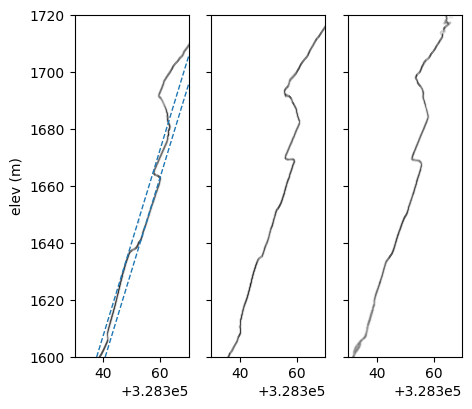

In [81]:
profiles = sorted(glob("Files/Cropped_Cable_Mtn_Profiles/Section cloud #*.txt"))

fig,ax = plt.subplots(1,3,figsize=(5,6),sharex=True,sharey=True)
prf1 = pd.read_csv(profiles[0],sep="\s+",header=None)
prf2 = pd.read_csv(profiles[1],sep="\s+",header=None)
prf3 = pd.read_csv(profiles[2],sep="\s+",header=None)

# Draw the cross-section profiles
ax[0].scatter(prf1[0],prf1[2],marker="$|$",s=0.7,c="k",alpha=0.01,ec=None)
ax[1].scatter(prf2[0],prf2[2],marker="$|$",s=0.7,c="k",alpha=0.01,ec=None)
ax[2].scatter(prf3[0],prf3[2],marker="$|$",s=0.7,c="k",alpha=0.01,ec=None)

# Estimate the width and height of the blocks
ax[0].axline((328353, 1650),slope=dip_to_slope(73.),c="C0",ls="--",lw=1)
ax[0].axline((328356, 1650),slope=dip_to_slope(73.),c="C0",ls="--",lw=1)

ax[0].set_xlim(328330,328370),ax[0].set_ylim(1600,1720),ax[0].set_ylabel("elev (m)")
# ax[0].set_xticks([328330,328350,328370])
ax[0].set_aspect("equal"),ax[1].set_aspect("equal"),ax[2].set_aspect("equal")

print(f"Block thickness: {round(np.cos(np.radians(73))*3,2)} m")
plt.show()

### Estimate Block dimensions

/var/folders/8_/3chn0d6s3hj2h7k0fsrgkzsh0000gn/T/ipykernel_4331/3738444501.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


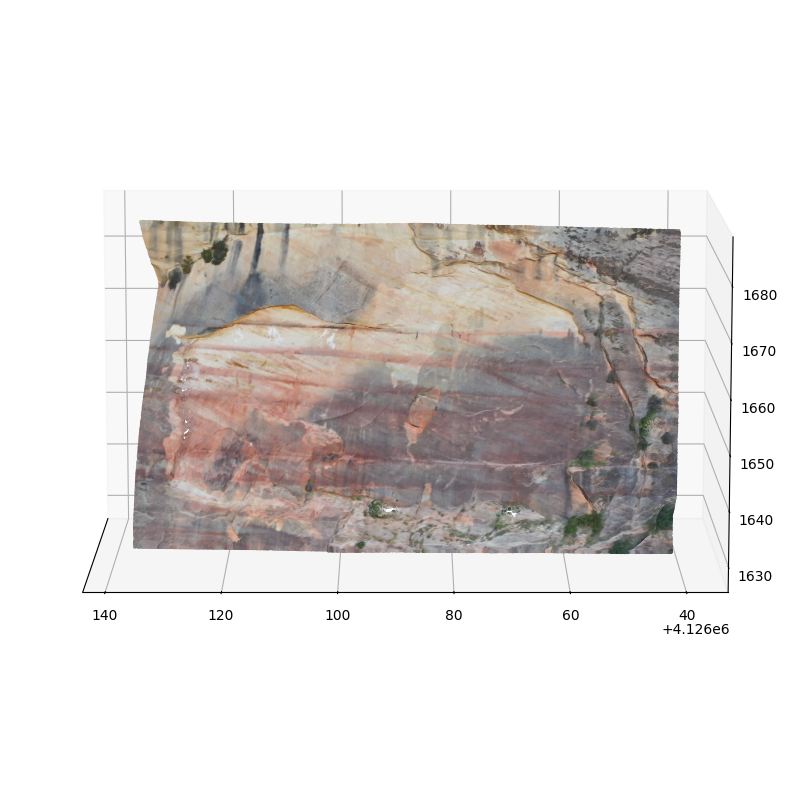

In [101]:
crp_bl = pd.read_csv("Files/Cropped_Cable_Mtn_Profiles/Rockfall_face.txt",sep="\s+",header=None)
blk_fc = crp_bl[[0,1,2]].to_numpy()
blk_col = crp_bl[[3,4,5]].to_numpy()

fig = plt.figure(figsize=(8,8), constrained_layout=True)
ax = fig.add_subplot(projection='3d')
ax.scatter(blk_fc[:,0],blk_fc[:,1],blk_fc[:,2],c=blk_col,s=1)
ax.view_init(elev=10., azim=180)
ax.margins(z=0.01),ax.set_xticks([])
# Set box aspect ratio to be non-equal
ax.set_box_aspect([1, 1.8, 1])
plt.tight_layout()
plt.show()

In [123]:
### Define the color scheme
def norm_colors(x):
    "Convert 16-bit colors for plotting"
    nor = (x/x.max()) # *255
    # nor = (x.max()-x)/(x.max()-x.min())
    return nor
r = norm_colors(ptcl.red)
g = norm_colors(ptcl.green)
b = norm_colors(ptcl.blue)
rgb = np.stack([r,g,b],axis=1)
pnts = np.stack([ptcl.X,ptcl.Y,ptcl.Z],axis=1)
filt = np.where(np.logical_and(pnts[:,0]>-8e4,pnts[:,0]<5e4))[0]
pnts = pnts[filt]
rgb = rgb[filt]

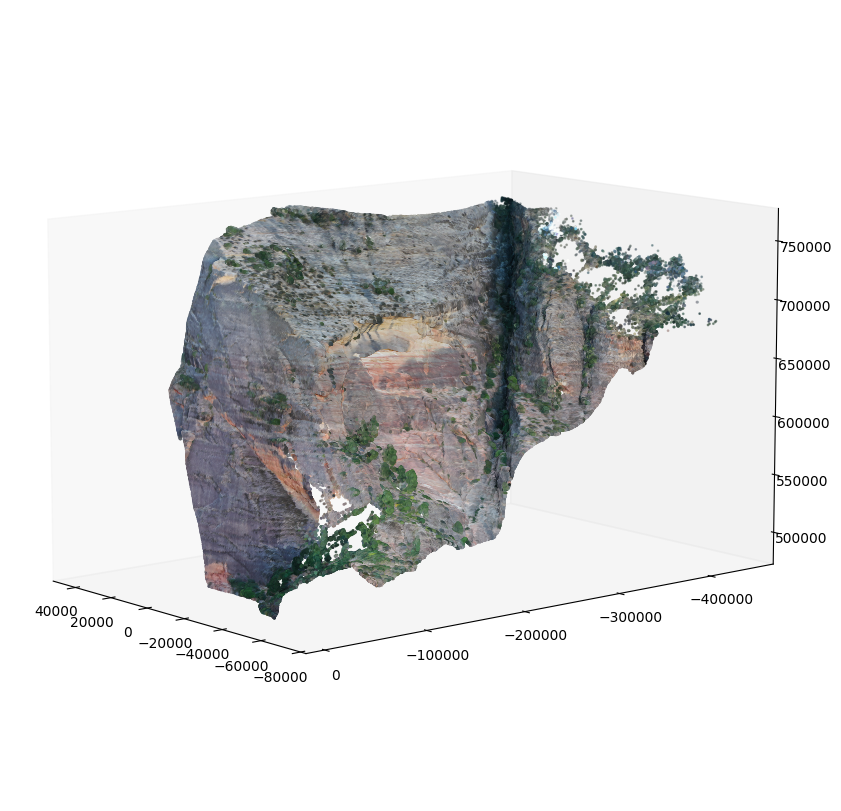

In [124]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)
dcm = 10
ax = fig.add_subplot(projection='3d')
ax.scatter(pnts[::dcm,0],pnts[::dcm,1],pnts[::dcm,2],c=rgb[::dcm],s=1)
ax.view_init(elev=10., azim=140)
ax.margins(z=0.01)
ax.set_xlim(-8e4,5e4)
# Set box aspect ratio to be non-equal
ax.set_box_aspect([1, 1.5, 0.9])
ax.grid(False)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()